In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras import Model,layers
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize,show_options
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [2]:
# downloading the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values

X = raw_data[:,:-1]     # Input Dataset
Y = raw_data[:,-1]      # Outoput Dataset

# splitting dataset into training and testing
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, random_state=21)

min_val = tf.reduce_min(X_train)  # minimum value of input
max_val = tf.reduce_max(X_train)  # maximum value of input

# min-max normalization
X_train = (X_train - min_val) / (max_val - min_val)
X_test = (X_test - min_val) / (max_val - min_val)

# converting inout dataset into tensors
X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)

Plotting the graph of a model

In [3]:
model = Sequential()

model.add(layers.Dense(64, activation="relu",name="encoder_dense_1",input_shape = (140,)))
model.add(layers.Dense(32, activation="relu",name="encoder_dense_2"))
model.add(layers.Dense(20, activation="linear",name="latent_space"))
model.add(layers.Dense(32, activation="relu",name="decoder_dense_1"))
model.add(layers.Dense(64, activation="relu",name="decoder_dense_2"))
model.add(layers.Dense(140, activation="sigmoid",name="output"))
model.compile(optimizer='adam',loss='mse')
model.fit(X_train,X_train)
gra = plot_model(model,to_file='autoencoder_structure.png',show_shapes=True,show_layer_activations=True,show_layer_names=True)


125/125 [==============================] - 1s 2ms/step - loss: 0.0030


In [3]:
# creating a class for an autoencoder model
class AnomalyDetector(Model):
    def __init__(self, latent_dim):
        super(AnomalyDetector, self).__init__()
        self.latent_dim = latent_dim    # number of neurons in the latent space
        # creating encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(64, activation="relu",name="encoder_dense_1"),
            layers.Dense(32, activation="relu",name="encoder_dense_2"),
            layers.Dense(self.latent_dim, activation="linear",name="latent_space") 
        ]) 
        # creating decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu",name="decoder_dense_1"),
            layers.Dense(64, activation="relu",name="decoder_dense_2"),
            layers.Dense(140, activation="sigmoid",name="output")
        ])

        # initializing a beta vector 
        self.beta = tf.Variable(tf.ones(shape=(self.latent_dim,)), name="beta",trainable=False)
        

    def call(self, X):
        encoded = tf.multiply(self.beta, self.encoder(X))
        decoded = self.decoder(encoded)
        
        return decoded  
    
autoencoder = AnomalyDetector(20)   # autoencoder model names autoencoder
autoencoder.compile(optimizer='adam', loss='mae')  # compiling the model

# setting early stopping criterion to reduce overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)
# training the model and saving the parameters into hostory variable
history = autoencoder.fit(X_train, X_train, epochs=1000, batch_size=512,validation_split=0.2,shuffle=True,callbacks=[early_stop])


Epoch 1/1000
7/7 [==============================] - 1s 46ms/step - loss: 0.0519 - val_loss: 0.0487
Epoch 2/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0464 - val_loss: 0.0436
Epoch 3/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.0415 - val_loss: 0.0392
Epoch 4/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.0376 - val_loss: 0.0359
Epoch 5/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0344 - val_loss: 0.0331
Epoch 6/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.0319 - val_loss: 0.0309
Epoch 7/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0296 - val_loss: 0.0284
Epoch 8/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0272 - val_loss: 0.0264
Epoch 9/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.0253 - val_loss: 0.0248
Epoch 10/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 11/1000
7/7

In [ ]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [4]:
lamda = [0,0.0001,0.001,0.01,0.1,1]

In [6]:
re = autoencoder.predict(X_test)
test_loss_a = tf.keras.losses.mae(re, X_test)
print(np.mean(test_loss_a))

32/32 [==============================] - 0s 1ms/step
0.007357782


Cobyla -- same as nm but no zeros - 2:0

In [5]:
class optimize_cb():
    def __init__(self, alpha, epoch= 1000,tol=1e-6):
        self.alpha = alpha  
        self.epoch = epoch
        self.tol = tol  
        self.coef = None 
        self.bias = None 

    def loss(self,beta_j,X,autoenoder,j):   
        autoencoder.beta[j].assign(beta_j)
        loss = (0.5/X.shape[0])* np.linalg.norm((X- autoencoder(X)),ord=2)**2 + self.alpha* np.linalg.norm(autoencoder.beta,ord=1)
        return loss    
    
    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0
    
    def fit(self, X,autoencoder):
           
        
        autoencoder.beta = tf.Variable(tf.ones(shape=(autoencoder.latent_dim,)), name="beta",trainable=False)        

        for iteration in range(self.epoch):  
            beta_old = np.copy(autoencoder.beta)          
                
            for j in range(autoencoder.latent_dim):      

                options = {'maxiter': 1000000}
                                    
                res = minimize(self.loss, x0=autoencoder.beta[j],args=(X,autoencoder,j), method='COBYLA', jac = False,options= options,tol=1e-6)
                        
                autoencoder.beta[j].assign(self.soft_threshold(res.x,1e-4))
                
                    
                
            if np.linalg.norm(autoencoder.beta - beta_old) < self.tol:
                #print("Optimization converged after l", iter+1, "iterations")
                break 

        self.coef = autoencoder.beta
        
        return self

In [75]:
opt_cb = optimize_cb(0.01,epoch=10)
opt_cb.fit(X_train,autoencoder)    
wo_cb = opt_cb.coef


re_cb = autoencoder(X_test)
test_loss_cb = tf.keras.losses.mae(re_cb, X_test)
print(np.mean(test_loss_cb))

0.027718933


In [ ]:
print(wo_cb)
print(np.where(wo_cb == 0)[0])

In [6]:
test_loss_cb = []
w_cb = []

for i in lamda:
    opt_cb = optimize_cb(i,epoch=10)
    opt_cb.fit(X_train,autoencoder)
    w_cb.append(opt_cb.coef) 
    print(f'lamda: {i}: {np.where(w_cb == 0)[0]}')   
    re_cb = autoencoder(X_test)
    test_loss_cb.append(np.mean(tf.keras.losses.mae(re_cb, X_test)))

lamda: 0: []
lamda: 0.0001: []
lamda: 0.001: []
lamda: 0.01: []
lamda: 0.1: []
lamda: 1: []


In [7]:
print(w_cb)
print(test_loss_cb)

[<tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([1.1165622 , 0.99518996, 0.87821615, 0.9760649 , 1.2810434 ,
       1.0875304 , 0.9820608 , 1.0498116 , 1.051924  , 1.0190804 ,
       1.0045731 , 1.0083869 , 1.0009427 , 0.9969572 , 0.99411607,
       0.99428207, 0.995581  , 0.95945007, 0.99927753, 0.97818685],
      dtype=float32)>, <tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([1.0849972 , 0.9698883 , 0.8485296 , 0.94910777, 0.5943627 ,
       1.0087012 , 0.99103117, 1.0001113 , 0.9589144 , 0.9860322 ,
       0.9684846 , 0.95203555, 1.0098554 , 0.98795164, 0.9391838 ,
       0.967178  , 0.9371049 , 0.8810823 , 1.0030612 , 0.7964017 ],
      dtype=float32)>, <tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([0.8029649 , 0.7879147 , 0.8400216 , 0.94902956, 0.43579236,
       0.75582165, 0.92003876, 0.7706635 , 0.8933377 , 0.7161289 ,
       0.94768757, 0.9295161 , 0.98813194, 0.9535574 , 0.7545808 ,
       0.9005293 , 0.89158857, 0.9434074 , 0.9

In [8]:
test_loss_lasso = [0.0053275838, 0.005442526, 0.0072445255, 0.019591725, 0.03206804, 0.03206804]

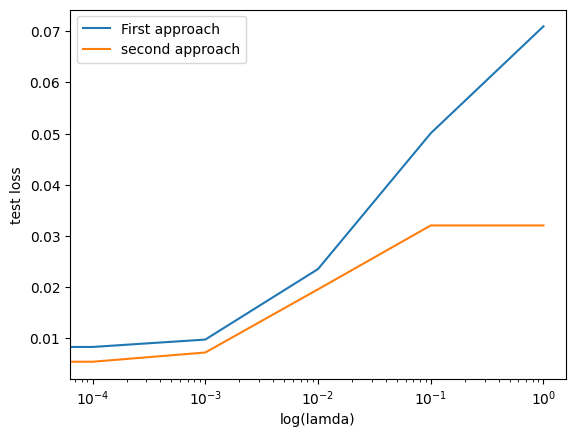

In [11]:
plt.plot(lamda,test_loss_cb,label = 'First approach')
plt.plot(lamda,test_loss_lasso,label='second approach')
plt.xscale("log")
plt.xlabel('log(lamda)')
plt.ylabel('test loss')
plt.legend()
plt.show()

In [5]:
class optimize_cb_all():
    def __init__(self, alpha, epoch= 1000,tol=1e-6):
        self.alpha = alpha  
        self.epoch = epoch
        self.tol = tol  
        self.coef = None 
        self.bias = None 

    def loss(self,beta,X):  
        autoencoder.beta.assign(beta) 
        loss = (0.5/X.shape[0])* np.linalg.norm((X- autoencoder(X)),ord=2)**2 + self.alpha* np.linalg.norm(autoencoder.beta,ord=1)
        return loss    
    
    def soft_threshold(self, rho, lamda):
        soft_threshold_vectorized = np.vectorize(lambda x: x + lamda if x < -lamda else (x - lamda if x > lamda else 0))
        return soft_threshold_vectorized(rho)
    
    def fit(self, X,autoencoder):

        autoencoder.beta = tf.Variable(tf.ones(shape=(autoencoder.latent_dim,)), name="beta",trainable=False) 

        #for iter in range(self.epoch):       
                    
        options = {'maxiter': 100000}
                                        
        res = minimize(self.loss, x0=autoencoder.beta,args=(X,autoencoder), method='COBYLA', jac = False,options= options,tol=1e-6)
                                   
        autoencoder.beta.assign(self.soft_threshold(res.x,1e-5))
                        
        print("Iterations: ", res.nfev)
        print(autoencoder.beta)

        self.coef = autoencoder.beta
        
        return self

In [ ]:
test_loss_cb_all = []
w_cb_all = []

for i in lamda:
    opt_cb_all = optimize_cb_all(i)
    opt_cb_all.fit(X_train,autoencoder)
    w_cb_all.append(opt_cb_all.coef) 
    print(np.where(w_cb_all == 0)[0])   
    re_cb_all = autoencoder(X_test)
    test_loss_cb_all.append(np.mean(tf.keras.losses.mae(re_cb_all, X_test)))

In [ ]:
print(test_loss_cb_all)
print(w_cb_all)

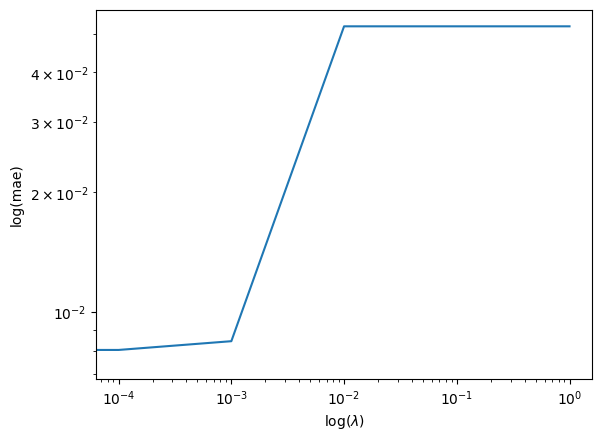

In [7]:
plt.plot(lamda,test_loss_cb_all)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(mae)')
plt.show()

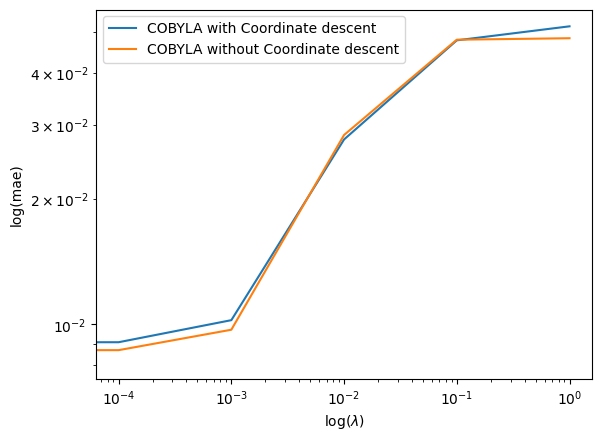

In [85]:
plt.plot(lamda,test_loss_cb,label = 'COBYLA with Coordinate descent')
plt.plot(lamda,test_loss_cb_all,label = 'COBYLA without Coordinate descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(mae)')
plt.legend()
plt.show()

Nelder Mead

In [86]:
class optimize_nm():
    def __init__(self, alpha, epoch= 1000,tol=1e-6):
        self.alpha = alpha  
        self.epoch = epoch
        self.tol = tol  
        self.coef = None 
        self.bias = None 

    def loss(self,beta_j,X,autoenoder,j):   
        autoencoder.beta[j].assign(beta_j)
        loss = (0.5/X.shape[0])* np.linalg.norm((X- autoencoder(X)),ord=2)**2 + self.alpha* np.linalg.norm(autoencoder.beta,ord=1)
        return loss    
    
    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0
    
    def fit(self, X,autoencoder):
           
        
        autoencoder.beta = tf.Variable(tf.ones(shape=(autoencoder.latent_dim,)), name="beta",trainable=False)        

        for iteration in range(self.epoch):  
            beta_old = np.copy(autoencoder.beta)          
                
            for j in range(autoencoder.latent_dim):      

                options = {'maxiter': 1000000}
                                    
                res = minimize(self.loss, x0=autoencoder.beta[j],args=(X,autoencoder,j), method='Nelder-Mead', jac = False,options= options)
                        
                autoencoder.beta[j].assign(self.soft_threshold(res.x,1e-4))
                
                    
                
            if np.linalg.norm(autoencoder.beta - beta_old) < self.tol:
                #print("Optimization converged after l", iter+1, "iterations")
                break 

        self.coef = autoencoder.beta
        
        return self

In [87]:
test_loss_nm = []
w_nm = []

for i in lamda:
    opt_nm = optimize_nm(i,epoch=10)
    opt_nm.fit(X_train,autoencoder)
    w_nm.append(opt_nm.coef) 
    #print(f'lamda: {i}: {np.where(w_cb == 0)[0]}')   
    re_nm = autoencoder(X_test)
    test_loss_nm.append(np.mean(tf.keras.losses.mae(re_nm, X_test)))

In [96]:
class optimize_nm_all():
    def __init__(self, alpha, epoch= 1000,tol=1e-6):
        self.alpha = alpha  
        self.epoch = epoch
        self.tol = tol  
        self.coef = None 
        self.bias = None 

    def loss(self,beta,X,autoenoder):  
        autoencoder.beta.assign(beta) 
        loss = (0.5/X.shape[0])* np.linalg.norm((X- autoencoder(X)),ord=2)**2 + self.alpha* np.linalg.norm(autoencoder.beta,ord=1)
        return loss    
    
    def soft_threshold(self, rho, lamda):
        soft_threshold_vectorized = np.vectorize(lambda x: x + lamda if x < -lamda else (x - lamda if x > lamda else 0))
        return soft_threshold_vectorized(rho)
    
    def fit(self, X,autoencoder):

        autoencoder.beta = tf.Variable(tf.ones(shape=(autoencoder.latent_dim,)), name="beta",trainable=False) 

        #for iter in range(self.epoch):       
                    
        options = {'maxiter': 100000}
                                        
        res = minimize(self.loss, x0=autoencoder.beta,args=(X,autoencoder), method='Nelder-Mead', jac = False,options= options,tol=1e-6)
                                   
        autoencoder.beta.assign(self.soft_threshold(res.x,1e-5))
                        
        print("Iterations: ", res.nfev)
        print(autoencoder.beta)

        self.coef = autoencoder.beta
        
        return self

In [97]:
test_loss_nm_all = []
w_nm_all = []

for i in lamda:
    opt_nm_all = optimize_nm_all(i)
    opt_nm_all.fit(X_train,autoencoder)
    w_nm_all.append(opt_nm_all.coef) 
    print(np.where(w_nm_all == 0)[0])   
    re_nm_all = autoencoder(X_test)
    test_loss_nm_all.append(np.mean(tf.keras.losses.mae(re_nm_all, X_test)))

Iterations:  2886
<tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([1.0527394 , 1.0241089 , 1.0167714 , 0.92411083, 1.057827  ,
       1.0011456 , 1.0547287 , 1.0477636 , 0.9789375 , 1.0100181 ,
       1.0223259 , 0.9866869 , 1.0117096 , 1.0613064 , 0.9720026 ,
       1.056449  , 0.9588421 , 1.0380577 , 1.0623835 , 0.8497074 ],
      dtype=float32)>
[]
Iterations:  5781
<tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([1.0432491 , 0.93936735, 1.0681676 , 0.8165878 , 0.92062664,
       0.9368312 , 0.90823406, 0.93579686, 1.0107676 , 0.9302809 ,
       0.96771055, 0.89603597, 1.1855378 , 0.9761448 , 1.0387818 ,
       1.0538542 , 0.9559464 , 0.9312711 , 1.0309888 , 0.83983845],
      dtype=float32)>
[]
Iterations:  7305
<tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([1.0309452 , 0.8174854 , 0.77910596, 0.8301049 , 0.736466  ,
       0.9600414 , 0.70273775, 0.86506593, 0.9729109 , 0.7303789 ,
       0.76416   , 0.4347911 , 1.0259143 , 0.6656864 , 0

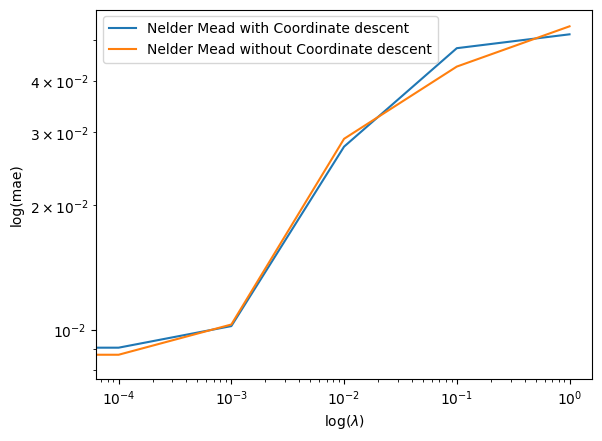

In [98]:
plt.plot(lamda,test_loss_nm,label = 'Nelder Mead with Coordinate descent')
plt.plot(lamda,test_loss_nm_all,label = 'Nelder Mead without Coordinate descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(mae)')
plt.legend()
plt.show()

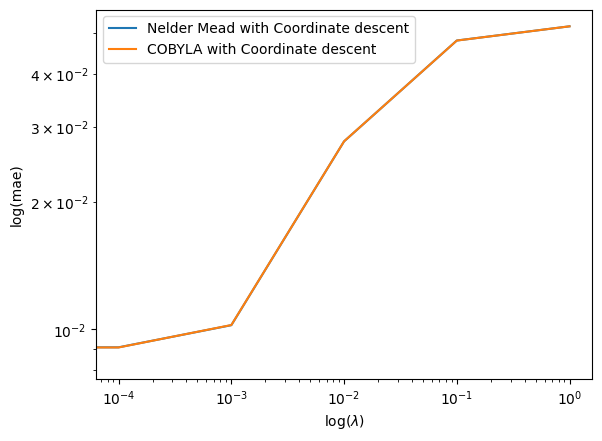

In [91]:
plt.plot(lamda,test_loss_nm,label = 'Nelder Mead with Coordinate descent')
plt.plot(lamda,test_loss_cb,label = 'COBYLA with Coordinate descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(mae)')
plt.legend()
plt.show()

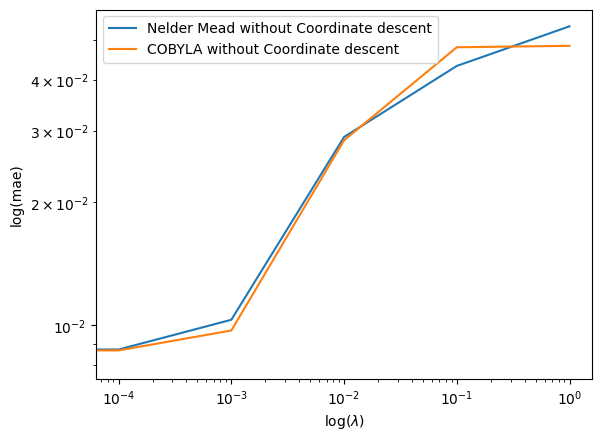

In [99]:
plt.plot(lamda,test_loss_nm_all,label = 'Nelder Mead without Coordinate descent')
plt.plot(lamda,test_loss_cb_all,label = 'COBYLA without Coordinate descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(mae)')
plt.legend()
plt.show()

L-BFGS-B

In [93]:
class optimize_l():
    def __init__(self, alpha, epoch= 1000,tol=1e-6):
        self.alpha = alpha  
        self.epoch = epoch
        self.tol = tol  
        self.coef = None 
        self.bias = None 

    def loss(self,beta_j,X,autoenoder,j):   
        autoencoder.beta[j].assign(beta_j)
        loss = (0.5/X.shape[0])* np.linalg.norm((X- autoencoder(X)),ord=2)**2 + self.alpha* np.linalg.norm(autoencoder.beta,ord=1)
        return loss    
    
    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0
    
    def fit(self, X,autoencoder):
           
        
        autoencoder.beta = tf.Variable(tf.ones(shape=(autoencoder.latent_dim,)), name="beta",trainable=False)        

        for iteration in range(self.epoch):  
            beta_old = np.copy(autoencoder.beta)          
                
            for j in range(autoencoder.latent_dim):      

                options = {'maxiter': 1000000}
                                    
                res = minimize(self.loss, x0=autoencoder.beta[j],args=(X,autoencoder,j), method='L-BFGS-B', jac = False,options= options)
                        
                autoencoder.beta[j].assign(self.soft_threshold(res.x,1e-4))
                
                    
                
            if np.linalg.norm(autoencoder.beta - beta_old) < self.tol:
                #print("Optimization converged after l", iter+1, "iterations")
                break 

        self.coef = autoencoder.beta
        
        return self

In [94]:
test_loss_l = []
w_l = []

for i in lamda:
    opt_l = optimize_l(i,epoch=10)
    opt_l.fit(X_train,autoencoder)
    w_l.append(opt_l.coef) 
    #print(f'lamda: {i}: {np.where(w_cb == 0)[0]}')   
    re_l = autoencoder(X_test)
    test_loss_l.append(np.mean(tf.keras.losses.mae(re_l, X_test)))

In [95]:
class optimize_l_all():
    def __init__(self, alpha, epoch= 1000,tol=1e-6):
        self.alpha = alpha  
        self.epoch = epoch
        self.tol = tol  
        self.coef = None 
        self.bias = None 

    def loss(self,beta,X,autoenoder):  
        autoencoder.beta.assign(beta) 
        loss = (0.5/X.shape[0])* np.linalg.norm((X- autoencoder(X)),ord=2)**2 + self.alpha* np.linalg.norm(autoencoder.beta,ord=1)
        return loss    
    
    def soft_threshold(self, rho, lamda):
        soft_threshold_vectorized = np.vectorize(lambda x: x + lamda if x < -lamda else (x - lamda if x > lamda else 0))
        return soft_threshold_vectorized(rho)
    
    def fit(self, X,autoencoder):

        autoencoder.beta = tf.Variable(tf.ones(shape=(autoencoder.latent_dim,)), name="beta",trainable=False) 

        #for iter in range(self.epoch):       
                    
        options = {'maxiter': 100000}
                                        
        res = minimize(self.loss, x0=autoencoder.beta,args=(X,autoencoder), method='L-BFGS-B', jac = False,options= options,tol=1e-6)
                                   
        autoencoder.beta.assign(self.soft_threshold(res.x,1e-5))
                        
        print("Iterations: ", res.nfev)
        print(autoencoder.beta)

        self.coef = autoencoder.beta
        
        return self

In [100]:
test_loss_l_all = []
w_l_all = []

for i in lamda:
    opt_l_all = optimize_l_all(i)
    opt_l_all.fit(X_train,autoencoder)
    w_l_all.append(opt_l_all.coef) 
    print(np.where(w_l_all == 0)[0])   
    re_l_all = autoencoder(X_test)
    test_loss_l_all.append(np.mean(tf.keras.losses.mae(re_l_all, X_test)))

Iterations:  21
<tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999,
       0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999,
       0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999],
      dtype=float32)>
[]
Iterations:  21
<tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999,
       0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999,
       0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999],
      dtype=float32)>
[]
Iterations:  21
<tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999,
       0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999,
       0.99999, 0.99999, 0.99999, 0.99999, 0.99999, 0.99999],
      dtype=float32)>
[]
Iterations:  21
<tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([0.99999, 0.99999, 0.9999

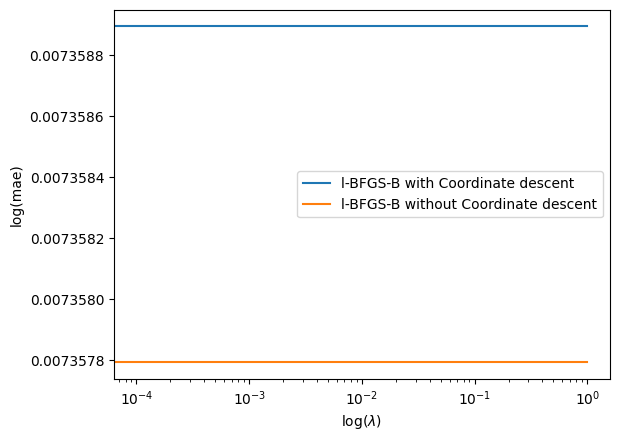

In [107]:
plt.plot(lamda,test_loss_l,label = 'l-BFGS-B with Coordinate descent')
plt.plot(lamda,test_loss_l_all,label = 'l-BFGS-B without Coordinate descent')
plt.xscale("log")
#plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(mae)')
plt.legend()
plt.show()

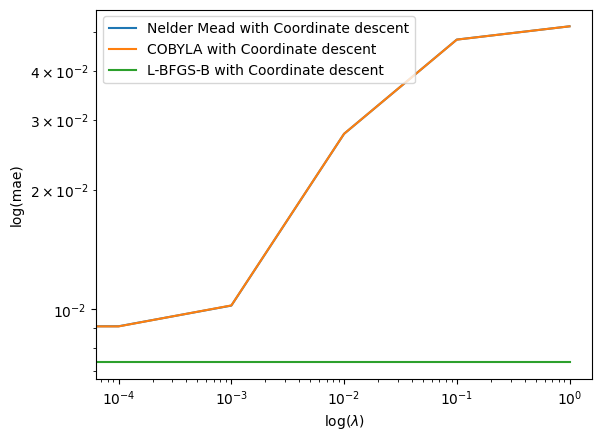

In [104]:
plt.plot(lamda,test_loss_nm,label = 'Nelder Mead with Coordinate descent')
plt.plot(lamda,test_loss_cb,label = 'COBYLA with Coordinate descent')
plt.plot(lamda,test_loss_l,label = 'L-BFGS-B with Coordinate descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(mae)')
plt.legend()
plt.show()

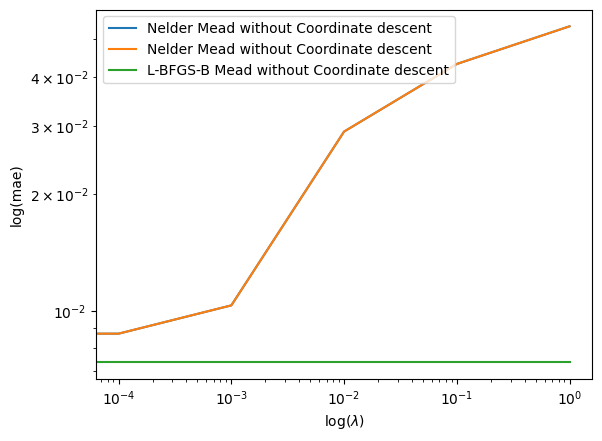

In [103]:
plt.plot(lamda,test_loss_nm_all,label = 'Nelder Mead without Coordinate descent')
plt.plot(lamda,test_loss_nm_all,label = 'Nelder Mead without Coordinate descent')
plt.plot(lamda,test_loss_l_all,label = 'L-BFGS-B Mead without Coordinate descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(mae)')
plt.legend()
plt.show()

In [23]:
test_loss_lasso = [0.00800002, 0.0080567833, 0.009545552, 0.021950012, 0.034340277, 0.034340277]
print(test_loss_cb_all)
print(test_loss_lasso)

[0.0074716234, 0.00802655, 0.008443727, 0.052252684, 0.052252684, 0.052252684]
[0.00800002, 0.0080567833, 0.009545552, 0.021950012, 0.034340277, 0.034340277]


In [25]:
print(w_cb_all)

[<tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([1.0284233 , 1.0008448 , 1.0353348 , 1.0545169 , 1.0370805 ,
       1.006612  , 0.9727892 , 0.9513095 , 0.86271894, 1.0033182 ,
       0.91664296, 1.0053055 , 0.92799294, 0.9988973 , 0.9675622 ,
       0.8575896 , 0.9792996 , 1.0337522 , 1.039401  , 0.96225774],
      dtype=float32)>, <tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([1.027723  , 0.9116137 , 0.8883878 , 1.096846  , 0.89281   ,
       0.96610403, 0.9581881 , 0.91767293, 0.88274676, 0.9557191 ,
       0.8118776 , 0.9142693 , 0.9690213 , 0.96209866, 1.0033972 ,
       0.8588899 , 0.97254133, 0.9342849 , 0.9477973 , 1.1043158 ],
      dtype=float32)>, <tf.Variable 'beta:0' shape=(20,) dtype=float32, numpy=
array([0.7838873 , 0.94538414, 0.9629951 , 0.8120782 , 0.9691585 ,
       0.918151  , 0.7999509 , 0.9387851 , 0.77986276, 0.88683003,
       0.85684127, 0.92653006, 0.8298066 , 0.9425631 , 0.80160445,
       0.838896  , 0.7287916 , 0.9718951 , 0.8

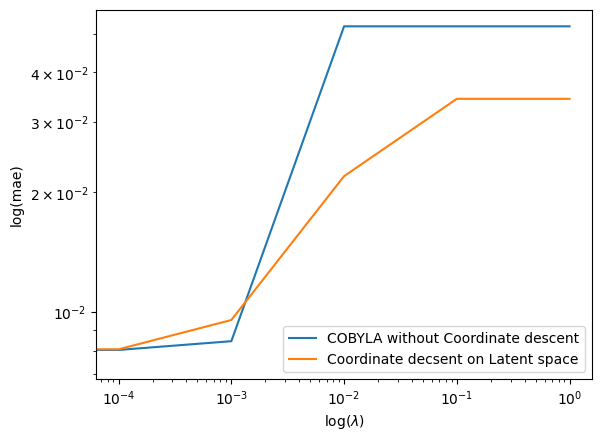

In [26]:
plt.plot(lamda,test_loss_cb_all,label = 'COBYLA without Coordinate descent')
plt.plot(lamda,test_loss_lasso,label = 'Coordinate decsent on Latent space')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(mae)')
plt.legend()
plt.show()